# Audio Experiment

In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import numpy as np
import random 
import os
import matplotlib.pyplot as plt
import math

In [2]:
np.set_printoptions(suppress=True)

In [3]:
# Params

frame_rate = 60
hop_window = 512

In [4]:
audio_duration = librosa.get_duration(librosa.load('Drums.wav', sr=22050)[0], sr=22050)
total_frames_float = audio_duration * frame_rate
total_frames = math.ceil(total_frames_float)
sample_rate = round(total_frames_float / audio_duration * hop_window)

audio_duration, sample_rate, total_frames

(8.347845804988662, 30720, 501)

In [5]:
y, sr = librosa.load('Drums.wav', sr=sample_rate) 

onset_strengths = librosa.onset.onset_strength(y=y, sr=sample_rate, aggregate=np.median)
onset_strengths = librosa.util.normalize(onset_strengths)
onset_times = librosa.times_like(onset_strengths, sr=sample_rate)
beat_times = librosa.beat.beat_track(y=y, sr=sample_rate, units='time')[1]

frames = onset_times.reshape((-1, 1)) * frame_rate

In [6]:
onset_strengths.shape, onset_times.shape, beat_times.shape

((501,), (501,), (14,))

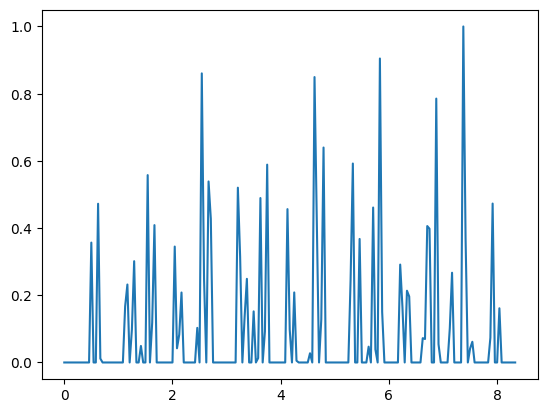

In [174]:
plt.plot(onset_times, onset_strengths)

In [7]:
def get_audio_params(audio_path, frame_rate=60, hop_window=512):
    # Load song with 22050 sample rate
    y, sr = librosa.load(audio_path, sr=22050)
    audio_duration = librosa.get_duration(y, sr=sr)
    
    total_frames_float = audio_duration * frame_rate
    total_frames = math.ceil(total_frames_float)
    
    sample_rate = round(total_frames_float / audio_duration * hop_window)
    
    return total_frames, sample_rate, audio_duration

In [8]:
def get_onset_info(audio_path, sample_rate, frame_rate=60, hop_window=512):
    # Load
    y, sr = librosa.load(audio_path, sr=sample_rate)
    
    # Onset strengths and normalize
    onset_strengths = librosa.onset.onset_strength(y=y, sr=sample_rate, aggregate=np.median)
    onset_strengths = librosa.util.normalize(onset_strengths)
    
    # Onset timestamps and frames
    onset_times = librosa.times_like(onset_strengths, sr=sample_rate)
    onset_frames = onset_times * frame_rate
    
    onset_info = np.concatenate([
        onset_frames.reshape((-1, 1)),
        onset_times.reshape((-1, 1)),
        onset_strengths.reshape((-1, 1))
    ], axis=1)
    
    # Beat times
    beat_times = librosa.beat.beat_track(y=y, sr=sample_rate, units='time')[1]
    
    return onset_info, beat_times

In [11]:
total_frames, sample_rate, audio_duration = get_audio_params('Drums.wav')

onset_info, beat_times = get_onset_info('Drums.wav', sample_rate)

In [15]:
onset_info.shape, total_frames

((501, 3), 501)

In [24]:
## Fixed Window linear decay

onset_info = np.concatenate([onset_info, np.zeros((total_frames,1))], axis=1)

In [26]:
onset_info

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  1.        ,   0.01666667,   0.        ,   0.        ],
       [  2.        ,   0.03333333,   0.        ,   0.        ],
       ...,
       [498.        ,   8.3       ,   0.        ,   0.        ],
       [499.        ,   8.31666667,   0.        ,   0.        ],
       [500.        ,   8.33333333,   0.00496167,   0.        ]])

# Beat track + Onset Strength

In [57]:
def detect_beat_track(audio_path):
    # Load audio
    file_path = audio_path
    y, sr = librosa.load(file_path, sr=22056)
    
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    
    # Extract beat_track
    beat_times = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, units='time')[1]
    
    # remove extension, .mp3, .wav etc.
    file_name_no_extension, _ = os.path.splitext(file_path)
    output_name = f'{file_name_no_extension}-beattrack2.txt'
    
    with open(output_name, 'wt') as f:
        f.write('\n'.join(['%.4f' % beat_time for beat_time in beat_times]))
    
    return beat_times

In [ ]:
def song_info(audio_path, duration, sample_rate=22056):
    
    y, _ = librosa.load(audio_path, duration=duration, sr=sample_rate)
    
    onset_strengths = librosa.onset.onset_strength(y=y, sr=sample_rate, aggregate=np.median, normalize=True)
    onset_times = librosa.times_like(onset_strengths, sr=sample_rate)
    onset_frames = librosa.time_to_frames(onset_times, sr=sample_rate)
    
    beat_times = librosa.beat.beat_track(onset_envelope=onset_strengths, sr=sample_rate, units='frame')[1]
    
    return 

In [58]:
beat_times = detect_beat_track('Drums.wav')
beat_times, beat_times.shape

(array([0.58034095, 1.11425462, 1.62495466, 2.1356547 , 2.64635473,
        3.18026841, 3.69096844, 4.22488212, 4.73558215, 5.29270947,
        5.8034095 , 6.31410954, 6.82480958, 7.35872325]),
 (14,))

In [164]:
beat_times

array([0.58333333, 1.1       , 1.6       , 2.11666667, 2.63333333,
       3.16666667, 3.68333333, 4.21666667, 4.73333333, 5.26666667,
       5.78333333, 6.31666667, 6.81666667, 7.35      ])

In [119]:
# Could be better, this combined with a magnitude (onset strength or energy) could be something
# TODO - find how to get relative energy at a time stamp

In [60]:
y, sr = librosa.load('Drums.wav', sr=22056)

onset_strengths = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
onset_strengths = librosa.util.normalize(onset_strengths)
onset_times = librosa.times_like(onset_strengths, sr=sr)

In [68]:
onset_times.shape

(360,)

In [65]:
# assign the normalised [0-1] onset_strength to the beat_timestamp

onset_info = []

for i, onset_strength in enumerate(onset_strengths):
    if onset_times[i] in beat_times:
        frame_no = (onset_times[i] / (1 / 24)).round()
        onset_info.append([frame_no, onset_times[i], onset_strength])
        
onset_info = np.array(onset_info)
onset_info

array([[ 14.        ,   0.58034095,   0.41137588],
       [ 27.        ,   1.11425462,   0.32329196],
       [ 39.        ,   1.62495466,   0.40977278],
       [ 51.        ,   2.1356547 ,   0.24511008],
       [ 64.        ,   2.64635473,   1.        ],
       [ 76.        ,   3.18026841,   0.78469652],
       [ 89.        ,   3.69096844,   0.59066838],
       [101.        ,   4.22488212,   0.26089489],
       [114.        ,   4.73558215,   0.81342959],
       [127.        ,   5.29270947,   0.55267984],
       [139.        ,   5.8034095 ,   0.92226344],
       [152.        ,   6.31410954,   0.1550526 ],
       [164.        ,   6.82480958,   0.82450378],
       [177.        ,   7.35872325,   0.72469407]])

In [78]:
# This appears to provide the closest frame number to the onset beat - alternatively we can assign it to the preceding frame
for i in range(len(onset_info)):
    print(int((onset_info[i, 1] / (1 / 24)).round()), (onset_info[i, 1] / (1 / 24)).round(2))

14 13.93
27 26.74
39 39.0
51 51.26
64 63.51
76 76.33
89 88.58
101 101.4
114 113.65
127 127.03
139 139.28
152 151.54
164 163.8
177 176.61


## All together

Returns a `numpy array` in the format of `[[frame_no], [timestamp(s)], [onset_strength]]` for each beat detected by `beat_track`.

In [113]:
# All together now:

def extract_onset_strength(audio_path: str, frame_rate=1/24, sample_rate=22056):
    '''
    Input:
        - audio_path: path to audio file | str
        - frame_rate: frame rate of created video | float
        - sample_rate: audio sample rate in samples per minute | int
    Returns:
        - np.ndarray: [[frame_num], [time_stamp], [onset_strength]]
    '''
    
    # Load Audio
    y, sr = librosa.load(audio_path, sr=sample_rate)
    
    # Onset Strength
    onset_strengths = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    onset_strengths = librosa.util.normalize(onset_strengths) # Normalise values to between 0 and 1
    onset_times = librosa.times_like(onset_strengths, sr=sr)
    
    # Onset Beat Timestamps 
    beat_times = librosa.beat.beat_track(onset_envelope=onset_strengths, sr=sr, units='time')[1]
    
    # Put it all in something 
    onset_info = []
    for i, onset_strength in enumerate(onset_strengths):
        if onset_times[i] in beat_times:
            frame_no = (onset_times[i] / (1 / 24)).round()
            onset_info.append([frame_no, onset_times[i], onset_strength])

    return np.array(onset_info)

In [114]:
drums_onset_info = extract_onset_strength('Drums.wav')
drums_onset_info

array([[ 14.        ,   0.58034095,   0.41137588],
       [ 27.        ,   1.11425462,   0.32329196],
       [ 39.        ,   1.62495466,   0.40977278],
       [ 51.        ,   2.1356547 ,   0.24511008],
       [ 64.        ,   2.64635473,   1.        ],
       [ 76.        ,   3.18026841,   0.78469652],
       [ 89.        ,   3.69096844,   0.59066838],
       [101.        ,   4.22488212,   0.26089489],
       [114.        ,   4.73558215,   0.81342959],
       [127.        ,   5.29270947,   0.55267984],
       [139.        ,   5.8034095 ,   0.92226344],
       [152.        ,   6.31410954,   0.1550526 ],
       [164.        ,   6.82480958,   0.82450378],
       [177.        ,   7.35872325,   0.72469407]])

In [3]:
# Visualise Info

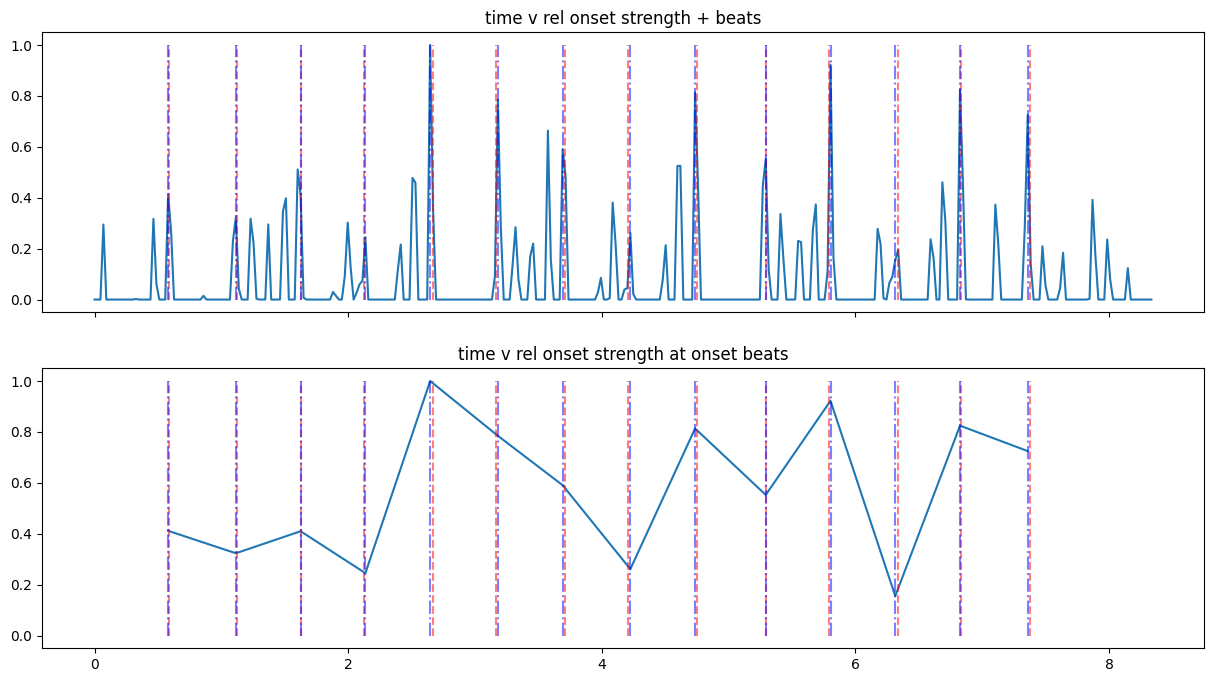

In [105]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15,8))

# fig.figsize=(15,8)

ax[0].plot(onset_times, onset_strengths, label='all values')
ax[0].vlines(drums_onset_info[:,0], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Frame')
ax[0].vlines(drums_onset_info[:,2], 0, 1, alpha=0.5, color='b',
           linestyle='-.', label='Beats')
ax[0].set(title='time v rel onset strength + beats')

ax[1].plot(drums_onset_info[:,2], drums_onset_info[:,3], label='onset beats')
ax[1].vlines(drums_onset_info[:,0], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Frame')
ax[1].vlines(drums_onset_info[:,2], 0, 1, alpha=0.5, color='b',
           linestyle='-.', label='Beats')
ax[1].set(title='time v rel onset strength at onset beats')
plt.show()

## Choice Example

In [135]:
# Requires
# pip install spleeter
# pip install ffmpeg-python
# sudo apt install ffmpeg <- LINUX/WSL ONLY, need something else for MacOS

In [6]:
import soundfile as sf
import spleeter as sp
from spleeter.audio.adapter import AudioAdapter

In [2]:
from spleeter.separator import Separator

2023-03-13 19:02:37.011462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 19:02:37.183281: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 19:02:37.222903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 19:02:37.222918: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [1]:
seperator = Separator(params_descriptor='spleeter:4stems')

NameError: name 'Separator' is not defined

In [8]:
# class LibAdapter(AudioAdapter):
#     def __init__(self, )

seperator.separate_to_file(
    'NjYyOTQ4MjM0NjYzMDA5_y7qiB5CYc9U.mp3', 
    '../raw_data/split_audio/',
    # audio_adapter=audio_adapter.load()
    duration=30,
)

NameError: name 'seperator' is not defined

In [161]:
y, sr = librosa.load('choice.wav', sr=44100, mono=True)
y.reshape((1, -1))

array([[ 0.00001143,  0.00000541,  0.00000061, ..., -0.02259809,
        -0.0204782 , -0.01075592]], dtype=float32)

In [ ]:
stems = seperator.separate(y.reshape((1, -1)), audio_descriptor='test')

In [ ]:
stems

In [ ]:
librosa

# Beat plp (predominant local pulse) detection

Had a brief look, this looks like a non-starter.

In [ ]:
def detect_beat_plp(audio_path):
    # Load audio
    file_path = audio_path
    y, sr = librosa.load(file_path)
    
    # extract plp
    plp_times = librosa.beat.plp(y=y, sr=sr)
    
    # remove extension, .mp3, .wav etc.
    file_name_no_extension, _ = os.path.splitext(file_path)
    output_name = f'{file_name_no_extension}-plp.txt'
    
    with open(output_name, 'wt') as f:
        f.write('\n'.join(['%.4f' % plp_time for plp_time in plp_times]))
    
    return plp_times

In [ ]:
librosa.beat.plp(y=y, sr=sr)

In [ ]:
beat_plp = detect_beat_plp('Drums.wav')

### Visualise

In [ ]:
y, sr = librosa.load('Drums.wav')
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
# Or compute pulse with an alternate prior, like log-normal
import scipy.stats
prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
pulse_lognorm = librosa.beat.plp(onset_envelope=onset_env, sr=sr,
                                 prior=prior)
melspec = librosa.feature.melspectrogram(y=y, sr=sr)

In [ ]:
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env)
beats_plp = np.flatnonzero(librosa.util.localmax(pulse))

# Plot beat_track
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
times = librosa.times_like(onset_env, sr=sr)
ax[0].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[0].vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
ax[0].legend()
ax[0].set(title='librosa.beat.beat_track')
ax[0].label_outer()

# Plot PLP
times = librosa.times_like(pulse, sr=sr)
ax[1].plot(times, librosa.util.normalize(pulse),
         label='PLP')
ax[1].vlines(times[beats_plp], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='PLP Beats')
ax[1].legend()
ax[1].set(title='librosa.beat.plp')
ax[1].xaxis.set_major_formatter(librosa.display.TimeFormatter())